In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#라이브러리 다운

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# for coloring maps
from matplotlib import colormaps

# for data visualizations

import plotly.express as px

# for preprocessing
from sklearn.preprocessing import StandardScaler

# for label encoding
from sklearn.preprocessing import LabelEncoder

# for data split
from sklearn.model_selection import train_test_split

In [ ]:
df_start=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cap/융합캡스톤디자인_최종데이터.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Cap/융합캡스톤디자인_최종데이터.csv'

In [ ]:
df_start

In [ ]:
df_start.info()

#위험도 점수 분석

In [ ]:
df = df_start[['SMOK_QTY','SMOK_STRT_AGE','SMOK_DTRN_YCNT','HORM_TRTM_YN',
                'HORM_TRTM_DTRN_DCNT','HORM_TRTM_PRPS_CD','MENO_YN','MENO_AGE',
                'UCLN_PRGN_YN','MENA_AGE','target']]

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.impute import SimpleImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor

df_Odds = pd.DataFrame(df)

# 독립 변수와 종속 변수 설정
y = df['target']
X = df[['SMOK_QTY','SMOK_STRT_AGE','SMOK_DTRN_YCNT','HORM_TRTM_YN',
                'HORM_TRTM_DTRN_DCNT','HORM_TRTM_PRPS_CD','MENO_YN','MENO_AGE',
                'UCLN_PRGN_YN','MENA_AGE']] #여기에 위험요인 칼럼 삽입 #여기에 위험요인 칼럼 삽입


##로지스틱 회귀분석

###모델학습

In [ ]:

# 상수 추가
X = sm.add_constant(X)

# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

# # 다중 공선성 높은 변수 제거 (예: 'INOP_AGE', 'IADM_AGE', 'HT_VL', 'IDGN_AGE', 'MENA_AGE' 제거)
# high_vif_columns = ['INOP_AGE', 'IADM_AGE', 'HT_VL', 'IDGN_AGE', 'MENA_AGE']
# X = X.drop(columns=high_vif_columns)

# 스케일링을 위해 상수열 제거
X_no_const = X.drop(columns=['const'])

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_const)

# 상수 열 추가
X_scaled = sm.add_constant(X_scaled)

# 로지스틱 회귀 모델 적합
logit_model = sm.Logit(y, X_scaled)

# 최대 반복 횟수 및 수렴 조건 설정
result = logit_model.fit(maxiter=100, method='lbfgs')

# 결과 요약 출력
print(result.summary())

    VIF Factor             features
0    29.157831                const
1     1.996379             SMOK_QTY
2     2.068262        SMOK_STRT_AGE
3     2.254562       SMOK_DTRN_YCNT
4     3.732207         HORM_TRTM_YN
5     3.155356  HORM_TRTM_DTRN_DCNT
6     1.198903    HORM_TRTM_PRPS_CD
7     3.595955              MENO_YN
8     3.234848             MENO_AGE
9     1.316473         UCLN_PRGN_YN
10    1.325301             MENA_AGE
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                23807
Model:                          Logit   Df Residuals:                    23796
Method:                           MLE   Df Model:                           10
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                  0.9234
Time:                        15:58:52   Log-Likelihood:                -1262.0
converged:                       True   LL-Null:                       -16474.
Covariance Type

In [ ]:
# 결과 요약 출력
print(result.summary())

# 오즈비 계산
odds_ratios = np.exp(result.params)
print("오즈비:")
print(odds_ratios)



                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                23807
Model:                          Logit   Df Residuals:                    23796
Method:                           MLE   Df Model:                           10
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                  0.9234
Time:                        15:58:52   Log-Likelihood:                -1262.0
converged:                       True   LL-Null:                       -16474.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.5820    889.688      0.043      0.965   -1705.175    1782.339
x1            13.3509    246.658      0.054      0.957    -470.089     496.791
x2            14.4562    161.088      0.090      0.9

###점수 구하기

In [ ]:
# 각 행에 대한 위험 점수 계산
# 회귀 계수를 Series로 변환
coefficients_series = pd.Series(result.params)

# 위험 점수 계산
risk_scores_lr = X_scaled.dot(coefficients_series)
# 'DIAG_YN'이 1인 행들 필터링
high_risk_patients_lr = risk_scores_lr[y == 1]

# 'high_risk_patients'를 pandas Series로 변환
high_risk_patients_series_lr = pd.Series(high_risk_patients_lr)

# 최대 위험 점수를 갖는 행 찾기
max_risk_index_diag_lr_1 = high_risk_patients_series_lr.idxmax()
max_risk_row_diag_lr_1 = X.loc[max_risk_index_diag_lr_1]

# 최대 위험 점수를 갖는 행의 위험 점수
max_risk_score_diag_lr_1 = high_risk_patients_series_lr.loc[max_risk_index_diag_lr_1]
print("DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행의 점수:", max_risk_score_diag_lr_1)
print("DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행:", max_risk_row_diag_lr_1)



DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행의 점수: 175.83122338241026
DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행: const                   1.0
SMOK_QTY               97.0
SMOK_STRT_AGE          86.0
SMOK_DTRN_YCNT         19.0
HORM_TRTM_YN            1.0
HORM_TRTM_DTRN_DCNT    73.0
HORM_TRTM_PRPS_CD       5.0
MENO_YN                 1.0
MENO_AGE               95.0
UCLN_PRGN_YN            1.0
MENA_AGE                8.0
Name: 3877, dtype: float64


In [ ]:
# 최소 위험 점수를 갖는 행 찾기
min_risk_index_diag_1 = high_risk_patients_series_lr.idxmin()
min_risk_row_diag_1 = X.loc[min_risk_index_diag_1]

# 최소 위험 점수를 갖는 행의 위험 점수
min_risk_score_diag_1 = high_risk_patients_series_lr.loc[min_risk_index_diag_1]
print("DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행의 점수:", min_risk_score_diag_1)
print("DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행:", min_risk_row_diag_1)


DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행의 점수: -4.517874992161233
DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행: const                   1.0
SMOK_QTY                0.0
SMOK_STRT_AGE           0.0
SMOK_DTRN_YCNT          0.0
HORM_TRTM_YN            0.0
HORM_TRTM_DTRN_DCNT     0.0
HORM_TRTM_PRPS_CD       0.0
MENO_YN                 0.0
MENO_AGE                0.0
UCLN_PRGN_YN            0.0
MENA_AGE               13.0
Name: 462, dtype: float64


###위험확률

In [ ]:
print(X.columns)

Index(['const', 'SMOK_QTY', 'SMOK_STRT_AGE', 'SMOK_DTRN_YCNT', 'HORM_TRTM_YN',
       'HORM_TRTM_DTRN_DCNT', 'HORM_TRTM_PRPS_CD', 'MENO_YN', 'MENO_AGE',
       'UCLN_PRGN_YN', 'MENA_AGE'],
      dtype='object')


In [ ]:
# 요인별 오즈비와 해당 요인의 사용자 입력 값을 곱하여 위험 점수 계산
risk_scores_per_row_lr = X_scaled.dot(coefficients_series)

# 최대 위험 점수
max_risk_score_lr = risk_scores_per_row_lr.max()

# 위험 점수를 100점 기준으로 변환하여 위험 백분위 계산
risk_percentiles_lr = (risk_scores_per_row_lr / max_risk_score_lr) * 100

# 데이터프레임에 위험 백분위 열 추가
X_with_risk_percentiles_lr = X.copy()
X_with_risk_percentiles_lr['Risk_Percentile'] = risk_percentiles_lr

# 결과 출력
print(X_with_risk_percentiles_lr)


       const  SMOK_QTY  SMOK_STRT_AGE  SMOK_DTRN_YCNT  HORM_TRTM_YN  \
0        1.0      79.0           36.0             8.0           0.0   
1        1.0      79.0           36.0             8.0           1.0   
2        1.0      68.0           35.0            13.0           1.0   
3        1.0       0.0            0.0             0.0           0.0   
4        1.0       0.0            0.0             0.0           0.0   
...      ...       ...            ...             ...           ...   
23802    1.0       0.0            0.0             0.0           0.0   
23803    1.0       0.0            0.0             0.0           0.0   
23804    1.0       0.0            0.0             0.0           0.0   
23805    1.0       0.0            0.0             0.0           0.0   
23806    1.0       0.0            0.0             0.0           0.0   

       HORM_TRTM_DTRN_DCNT  HORM_TRTM_PRPS_CD  MENO_YN  MENO_AGE  \
0                      0.0                0.0      1.0      12.0   
1          

In [ ]:

df['Risk_Percentile_lr'] = risk_percentiles_lr

<ipython-input-17-fa953bd22db4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Risk_Percentile_lr'] = risk_percentiles_lr


In [ ]:
df

,SMOK_QTY,SMOK_STRT_AGE,SMOK_DTRN_YCNT,HORM_TRTM_YN,HORM_TRTM_DTRN_DCNT,HORM_TRTM_PRPS_CD,MENO_YN,MENO_AGE,UCLN_PRGN_YN,MENA_AGE,target,Risk_Percentile_lr
0,79.0,36.0,8.0,0.0,0.0,0.0,1.0,12.0,0.0,13.0,1.0,50.616313
1,79.0,36.0,8.0,1.0,47.0,99.0,0.0,0.0,1.0,9.0,1.0,54.236814
2,68.0,35.0,13.0,1.0,91.0,99.0,0.0,0.0,0.0,10.0,1.0,53.362199
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,93.0,1.0,10.0,1.0,15.621564
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,-1.850397
...,...,...,...,...,...,...,...,...,...,...,...,...
23802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,9.6,0.0,0.183122
23803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,14.4,0.0,-1.542577
23804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.9,0.0,-4.331090
23805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,16.3,0.0,-2.225667


In [ ]:
# 'target'이 1인 데이터 필터링
target_1_df = df[df['target'] == 1]

# 'Risk_score'의 최대값과 최저값 계산
max_risk_score_diag_yn_1_lr = target_1_df['Risk_Percentile_lr'].max()
min_risk_score_diag_yn_1_lr = target_1_df['Risk_Percentile_lr'].min()

print(f"Max Risk Score 환자군 lr: {max_risk_score_diag_yn_1_lr}")
print(f"Min Risk Score 환자군 lr: {min_risk_score_diag_yn_1_lr}")


Max Risk Score 환자군 lr: 100.0
Min Risk Score 환자군 lr: -2.5694384110240973


In [ ]:

# # CSV 파일로 저장
# df.to_csv('/content/drive/MyDrive/캡디/df_Risk_score_included_0530_변수들추출후.csv', index=False)

##random forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor


###모델학습

In [ ]:
# 결측치 처리
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# VIF 계산을 위한 상수 추가
X_const = sm.add_constant(X_imputed)

# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_const, i) for i in range(X_const.shape[1])]
vif["features"] = X.columns
print(vif)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest 모델 적합
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 예측
y_pred_rf = rf.predict(X_test)

# 결과 출력
print(f'Random Forest 정확도: {accuracy_score(y_test, y_pred_rf)}')
print(f'혼동 행렬:\n{confusion_matrix(y_test, y_pred_rf)}')
print(f'분류 보고서:\n{classification_report(y_test, y_pred_rf)}')

# 변수 중요도 출력
feature_importances = rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("변수 중요도:")
print(importance_df)

    VIF Factor             features
0    29.157831                const
1     1.996379             SMOK_QTY
2     2.068262        SMOK_STRT_AGE
3     2.254562       SMOK_DTRN_YCNT
4     3.732207         HORM_TRTM_YN
5     3.155356  HORM_TRTM_DTRN_DCNT
6     1.198903    HORM_TRTM_PRPS_CD
7     3.595955              MENO_YN
8     3.234848             MENO_AGE
9     1.316473         UCLN_PRGN_YN
10    1.325301             MENA_AGE
Random Forest 정확도: 0.9928601427971441
혼동 행렬:
[[2237    6]
 [  28 2491]]
분류 보고서:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2243
         1.0       1.00      0.99      0.99      2519

    accuracy                           0.99      4762
   macro avg       0.99      0.99      0.99      4762
weighted avg       0.99      0.99      0.99      4762

변수 중요도:
                Feature  Importance
3        SMOK_DTRN_YCNT    0.205823
2         SMOK_STRT_AGE    0.177794
1              SMOK_QTY    0.162952
10       

###점수구하기

In [ ]:
# 각 행에 대한 위험 점수 계산
# 클래스 1의 예측 확률을 위험 점수로 사용합니다.
risk_scores_rf = rf.predict_proba(X_scaled)[:, 1]

# 'target'이 1인 행들 필터링
high_risk_patients_rf = risk_scores_rf[y == 1]

# 'high_risk_patients'를 pandas Series로 변환
high_risk_patients_series_rf = pd.Series(high_risk_patients_rf)

# 최대 위험 점수를 갖는 행 찾기
max_risk_index_diag_rf_1 = high_risk_patients_series_rf.idxmax()
max_risk_row_diag_rf_1 = X.loc[max_risk_index_diag_rf_1]

# 최대 위험 점수를 갖는 행의 위험 점수
max_risk_score_diag_rf_1 = high_risk_patients_series_rf.loc[max_risk_index_diag_rf_1]
print("DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행의 점수:", max_risk_score_diag_rf_1)
print("DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행:", max_risk_row_diag_rf_1)


DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행의 점수: 1.0
DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행: const                   1.0
SMOK_QTY               79.0
SMOK_STRT_AGE          36.0
SMOK_DTRN_YCNT          8.0
HORM_TRTM_YN            0.0
HORM_TRTM_DTRN_DCNT     0.0
HORM_TRTM_PRPS_CD       0.0
MENO_YN                 1.0
MENO_AGE               12.0
UCLN_PRGN_YN            0.0
MENA_AGE               13.0
Name: 0, dtype: float64


In [ ]:
# 최소 위험 점수를 갖는 행 찾기
min_risk_index_diag_rf_1 = high_risk_patients_series_rf.idxmin()
min_risk_row_diag_rf_1 = X.loc[min_risk_index_diag_rf_1]

# 최소 위험 점수를 갖는 행의 위험 점수
min_risk_score_diag_rf_1 = high_risk_patients_series_rf.loc[min_risk_index_diag_rf_1]
print("DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행의 점수:", min_risk_score_diag_rf_1)
print("DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행:", min_risk_row_diag_rf_1)


DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행의 점수: 0.05
DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행: const                   1.0
SMOK_QTY                0.0
SMOK_STRT_AGE           0.0
SMOK_DTRN_YCNT          0.0
HORM_TRTM_YN            0.0
HORM_TRTM_DTRN_DCNT     0.0
HORM_TRTM_PRPS_CD       0.0
MENO_YN                 0.0
MENO_AGE                0.0
UCLN_PRGN_YN            1.0
MENA_AGE               14.0
Name: 10290, dtype: float64


###위험확률

In [ ]:
# 각 행에 대한 위험 점수 계산
risk_scores_per_row_rf = rf.predict_proba(X_scaled)[:, 1]

# 최대 위험 점수
max_risk_score_rf = risk_scores_per_row_rf.max()

# 위험 점수를 100점 기준으로 변환하여 위험 백분위 계산
risk_percentiles_rf = (risk_scores_per_row_rf / max_risk_score_rf) * 100

# 데이터프레임에 위험 백분위 열 추가
X_with_risk_percentiles_rf = X.copy()
X_with_risk_percentiles_rf['Risk_Percentile'] = risk_percentiles_rf

# 결과 출력
print(X_with_risk_percentiles_rf)


       const  SMOK_QTY  SMOK_STRT_AGE  SMOK_DTRN_YCNT  HORM_TRTM_YN  \
0        1.0      79.0           36.0             8.0           0.0   
1        1.0      79.0           36.0             8.0           1.0   
2        1.0      68.0           35.0            13.0           1.0   
3        1.0       0.0            0.0             0.0           0.0   
4        1.0       0.0            0.0             0.0           0.0   
...      ...       ...            ...             ...           ...   
23802    1.0       0.0            0.0             0.0           0.0   
23803    1.0       0.0            0.0             0.0           0.0   
23804    1.0       0.0            0.0             0.0           0.0   
23805    1.0       0.0            0.0             0.0           0.0   
23806    1.0       0.0            0.0             0.0           0.0   

       HORM_TRTM_DTRN_DCNT  HORM_TRTM_PRPS_CD  MENO_YN  MENO_AGE  \
0                      0.0                0.0      1.0      12.0   
1          

In [ ]:

df['Risk_Percentile_rf'] = risk_percentiles_rf

<ipython-input-26-cefa4b9237de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Risk_Percentile_rf'] = risk_percentiles_rf


In [ ]:
# 'target'이 1인 데이터 필터링
target_1_df = df[df['target'] == 1]

# 'Risk_score'의 최대값과 최저값 계산
max_risk_score_diag_yn_1_rf = target_1_df['Risk_Percentile_rf'].max()
min_risk_score_diag_yn_1_rf = target_1_df['Risk_Percentile_rf'].min()

print(f"Max Risk Score 환자군: {max_risk_score_diag_yn_1_rf}")
print(f"Min Risk Score 환자군: {min_risk_score_diag_yn_1_rf}")


Max Risk Score 환자군: 100.0
Min Risk Score 환자군: 5.0


##ANN

In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


###모델학습

In [ ]:

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ANN 모델 정의
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

# 모델 평가
y_pred_ann = (model.predict(X_test) > 0.5).astype("int32")
accuracy_ann = accuracy_score(y_test, y_pred_ann)

print(f'Test Accuracy ann: {accuracy_ann}')

# 모델 요약 출력
model.summary()

# 가중치 확인
weights = model.get_weights()

for layer_num, layer_weights in enumerate(weights):
    print(f"Layer {layer_num + 1} weights shape: {layer_weights.shape}")
    print(layer_weights)

Epoch 1/10
1905/1905 [==============================] - 11s 5ms/step - loss: 0.0997 - accuracy: 0.9730 - val_loss: 0.0407 - val_accuracy: 0.9893
Epoch 2/10
1905/1905 [==============================] - 4s 2ms/step - loss: 0.0613 - accuracy: 0.9861 - val_loss: 0.0400 - val_accuracy: 0.9893
Epoch 3/10
1905/1905 [==============================] - 4s 2ms/step - loss: 0.0569 - accuracy: 0.9869 - val_loss: 0.0367 - val_accuracy: 0.9916
Epoch 4/10
1905/1905 [==============================] - 6s 3ms/step - loss: 0.0553 - accuracy: 0.9875 - val_loss: 0.0388 - val_accuracy: 0.9920
Epoch 5/10
1905/1905 [==============================] - 4s 2ms/step - loss: 0.0532 - accuracy: 0.9876 - val_loss: 0.0362 - val_accuracy: 0.9920
Epoch 6/10
1905/1905 [==============================] - 4s 2ms/step - loss: 0.0525 - accuracy: 0.9876 - val_loss: 0.0364 - val_accuracy: 0.9922
Epoch 7/10
1905/1905 [==============================] - 7s 3ms/step - loss: 0.0512 - accuracy: 0.9877 - val_loss: 0.0351 - val_accuracy

###점수구하기

In [ ]:
# 각 행에 대한 위험 점수 계산
risk_scores_ann = model.predict(X_scaled)

# 'DIAG_YN'이 1인 행들 필터링
high_risk_patients_ann = risk_scores_ann[y == 1]

# 'high_risk_patients'를 pandas Series로 변환
high_risk_patients_series_ann = pd.Series(np.squeeze(high_risk_patients_ann))

# 최대 위험 점수를 갖는 행 찾기
max_risk_index_diag_ann_1 = high_risk_patients_series_ann.idxmax()
max_risk_row_diag_ann_1 = X.loc[max_risk_index_diag_ann_1]

# 최대 위험 점수를 갖는 행의 위험 점수
max_risk_score_diag_ann_1 = high_risk_patients_series_ann.loc[max_risk_index_diag_ann_1]
print("DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행의 점수:", max_risk_score_diag_ann_1)
print("DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행:", max_risk_row_diag_ann_1)


744/744 [==============================] - 1s 1ms/step
DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행의 점수: 1.0
DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행: const                   1.0
SMOK_QTY               79.0
SMOK_STRT_AGE          36.0
SMOK_DTRN_YCNT          8.0
HORM_TRTM_YN            0.0
HORM_TRTM_DTRN_DCNT     0.0
HORM_TRTM_PRPS_CD       0.0
MENO_YN                 1.0
MENO_AGE               12.0
UCLN_PRGN_YN            0.0
MENA_AGE               13.0
Name: 0, dtype: float64


In [ ]:
# 최소 위험 점수를 갖는 행 찾기
min_risk_index_diag_ann_1 = high_risk_patients_series_ann.idxmin()
min_risk_row_diag_ann_1 = X.loc[min_risk_index_diag_ann_1]

# 최소 위험 점수를 갖는 행의 위험 점수
min_risk_score_diag_ann_1 = high_risk_patients_series_ann.loc[min_risk_index_diag_ann_1]
print("DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행의 점수:", min_risk_score_diag_ann_1)
print("DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행:", min_risk_row_diag_ann_1)


DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행의 점수: 0.0006600205
DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행: const                   1.0
SMOK_QTY               23.0
SMOK_STRT_AGE          14.0
SMOK_DTRN_YCNT          1.0
HORM_TRTM_YN            0.0
HORM_TRTM_DTRN_DCNT     0.0
HORM_TRTM_PRPS_CD       0.0
MENO_YN                 0.0
MENO_AGE                0.0
UCLN_PRGN_YN            0.0
MENA_AGE               15.0
Name: 2480, dtype: float64


###위험확률

In [ ]:
# 각 행에 대한 위험 점수 계산
risk_scores_per_row_ann = model.predict(X_scaled)

# 최대 위험 점수
max_risk_score_ann = risk_scores_per_row_ann.max()

# 위험 점수를 100점 기준으로 변환하여 위험 백분위 계산
risk_percentiles_ann = (risk_scores_per_row_ann / max_risk_score_ann) * 100

# 데이터프레임에 위험 백분위 열 추가
X_with_risk_percentiles_ann = X.copy()
X_with_risk_percentiles_ann['Risk_Percentile'] = risk_percentiles_ann

# 결과 출력
print(X_with_risk_percentiles_ann)


744/744 [==============================] - 1s 1ms/step
       const  SMOK_QTY  SMOK_STRT_AGE  SMOK_DTRN_YCNT  HORM_TRTM_YN  \
0        1.0      79.0           36.0             8.0           0.0   
1        1.0      79.0           36.0             8.0           1.0   
2        1.0      68.0           35.0            13.0           1.0   
3        1.0       0.0            0.0             0.0           0.0   
4        1.0       0.0            0.0             0.0           0.0   
...      ...       ...            ...             ...           ...   
23802    1.0       0.0            0.0             0.0           0.0   
23803    1.0       0.0            0.0             0.0           0.0   
23804    1.0       0.0            0.0             0.0           0.0   
23805    1.0       0.0            0.0             0.0           0.0   
23806    1.0       0.0            0.0             0.0           0.0   

       HORM_TRTM_DTRN_DCNT  HORM_TRTM_PRPS_CD  MENO_YN  MENO_AGE  \
0                      0

In [ ]:

df['Risk_Percentile_ann'] = risk_percentiles_ann

<ipython-input-33-61d79e60e43e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Risk_Percentile_ann'] = risk_percentiles_ann


In [ ]:
# 'target'이 1인 데이터 필터링
target_1_df = df[df['target'] == 1]

# 'Risk_Percentile_ann'의 최대값과 최소값 계산
max_risk_score_diag_yn_1_ann = target_1_df['Risk_Percentile_ann'].max()
min_risk_score_diag_yn_1_ann = target_1_df['Risk_Percentile_ann'].min()

print(f"Max Risk Score 환자군 ann: {max_risk_score_diag_yn_1_ann}")
print(f"Min Risk Score 환자군 ann: {min_risk_score_diag_yn_1_ann}")


Max Risk Score 환자군 ann: 100.0
Min Risk Score 환자군 ann: 0.06600204855203629


##그래디언트 부스팅

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


###모델학습

In [ ]:

# 데이터 프레임 복사
df_Odds = pd.DataFrame(df)


# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 그래디언트 부스팅 분류기 초기화 및 학습
gb_model = GradientBoostingClassifier(learning_rate = 0.07,    # 기존 모델 0.1
                                     max_depth = 1,           # 기존 모델 3
                                     min_samples_leaf = 3,    # 기존 모델 1
                                     min_samples_split = 3,   # 기존 모델 2
                                     n_estimators = 300)
gb_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred_gbm = gb_model.predict(X_test)

# 정확도 계산
accuracy_gbm = (y_pred_gbm == y_test).mean()
print("정확도:", accuracy_gbm)

정확도: 0.9922301553968921


In [ ]:
# 모델에서 특성 중요도 확인
feature_importances = gb_model.feature_importances_

# 특성 중요도 출력
print("특성 중요도:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")


특성 중요도:
const: 0.0
SMOK_QTY: 0.28558213172146235
SMOK_STRT_AGE: 0.2503738697194017
SMOK_DTRN_YCNT: 0.051589389750209574
HORM_TRTM_YN: 0.03435891962953268
HORM_TRTM_DTRN_DCNT: 0.037472634284789114
HORM_TRTM_PRPS_CD: 0.020398201679367144
MENO_YN: 0.03663260107330785
MENO_AGE: 0.060745480985653966
UCLN_PRGN_YN: 0.07651649722446983
MENA_AGE: 0.14633027393180567


###점수구하기

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# 그래디언트 부스팅 모델 학습
gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm.fit(X_scaled, y)

# 각 행에 대한 예측 확률 계산
predicted_probabilities = gbm.predict_proba(X_scaled)[:, 1]

# 위험 점수를 Series로 변환
risk_scores_gbm = pd.Series(predicted_probabilities, index=X.index)

# 'target'이 1인 행들 필터링
high_risk_patients_gbm = risk_scores_gbm[y == 1]

# 최대 위험 점수를 갖는 행 찾기
max_risk_index_diag_gbm_1 = high_risk_patients_gbm.idxmax()
max_risk_row_diag_gbm_1 = X.loc[max_risk_index_diag_gbm_1]

# 최대 위험 점수를 갖는 행의 위험 점수
max_risk_score_diag_gbm_1 = high_risk_patients_gbm.loc[max_risk_index_diag_gbm_1]
print("DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행의 점수:", max_risk_score_diag_gbm_1)
print("DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행:", max_risk_row_diag_gbm_1)


DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행의 점수: 0.9997407352330651
DIAG_YN=1인 행들 중 최대 위험 점수를 갖는 행: const                   1.0
SMOK_QTY               60.0
SMOK_STRT_AGE          86.0
SMOK_DTRN_YCNT         11.0
HORM_TRTM_YN            1.0
HORM_TRTM_DTRN_DCNT    79.0
HORM_TRTM_PRPS_CD       1.0
MENO_YN                 1.0
MENO_AGE               59.0
UCLN_PRGN_YN            1.0
MENA_AGE               14.0
Name: 926, dtype: float64


In [ ]:

# 최소 위험 점수를 갖는 행 찾기
min_risk_index_diag_gbm_1 = high_risk_patients_gbm.idxmin()
min_risk_row_diag_gbm_1 = X.loc[min_risk_index_diag_gbm_1]

# 최소 위험 점수를 갖는 행의 위험 점수
min_risk_score_diag_gbm_1 = high_risk_patients_gbm.loc[min_risk_index_diag_gbm_1]
print("DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행의 점수:", min_risk_score_diag_gbm_1)
print("DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행:", min_risk_row_diag_gbm_1)

DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행의 점수: 0.183125987016403
DIAG_YN=1인 행들 중 최소 위험 점수를 갖는 행: const                   1.0
SMOK_QTY                0.0
SMOK_STRT_AGE           0.0
SMOK_DTRN_YCNT          0.0
HORM_TRTM_YN            0.0
HORM_TRTM_DTRN_DCNT     0.0
HORM_TRTM_PRPS_CD       0.0
MENO_YN                 0.0
MENO_AGE                0.0
UCLN_PRGN_YN            1.0
MENA_AGE               14.0
Name: 10290, dtype: float64


###위험확률

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# 그래디언트 부스팅 모델 학습
gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm.fit(X_scaled, y)

# 각 행에 대한 예측 확률 계산
predicted_probabilities = gbm.predict_proba(X_scaled)[:, 1]

# 위험 점수 계산 (예측 확률을 위험 점수로 사용)
risk_scores_gbm = pd.Series(predicted_probabilities, index=X.index)

# 최대 위험 점수
max_risk_score_gbm = risk_scores_gbm.max()

# 위험 점수를 100점 기준으로 변환하여 위험 백분위 계산
risk_percentiles_gbm = (risk_scores_gbm / max_risk_score_gbm) * 100

# 데이터프레임에 위험 백분위 열 추가
X_with_risk_percentiles_gbm = X.copy()
X_with_risk_percentiles_gbm['Risk_Percentile_gbm'] = risk_percentiles_gbm

# 결과 출력
print(X_with_risk_percentiles_gbm)


       const  SMOK_QTY  SMOK_STRT_AGE  SMOK_DTRN_YCNT  HORM_TRTM_YN  \
0        1.0      79.0           36.0             8.0           0.0   
1        1.0      79.0           36.0             8.0           1.0   
2        1.0      68.0           35.0            13.0           1.0   
3        1.0       0.0            0.0             0.0           0.0   
4        1.0       0.0            0.0             0.0           0.0   
...      ...       ...            ...             ...           ...   
23802    1.0       0.0            0.0             0.0           0.0   
23803    1.0       0.0            0.0             0.0           0.0   
23804    1.0       0.0            0.0             0.0           0.0   
23805    1.0       0.0            0.0             0.0           0.0   
23806    1.0       0.0            0.0             0.0           0.0   

       HORM_TRTM_DTRN_DCNT  HORM_TRTM_PRPS_CD  MENO_YN  MENO_AGE  \
0                      0.0                0.0      1.0      12.0   
1          

In [ ]:

df['Risk_Percentile_gbm'] = risk_percentiles_gbm

<ipython-input-49-d7be046541c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Risk_Percentile_gbm'] = risk_percentiles_gbm


In [ ]:
# 'target'이 1인 데이터 필터링
target_1_df = df[df['target'] == 1]

# 그래디언트 부스팅 모델을 사용하여 계산된 'Risk_Percentile'의 최대값과 최저값 계산
max_risk_score_diag_yn_1_gbm = target_1_df['Risk_Percentile_gbm'].max()
min_risk_score_diag_yn_1_gbm = target_1_df['Risk_Percentile_gbm'].min()

print(f"Max Risk Score 환자군 gbm: {max_risk_score_diag_yn_1_gbm}")
print(f"Min Risk Score 환자군 gbm: {min_risk_score_diag_yn_1_gbm}")


Max Risk Score 환자군 gbm: 100.0
Min Risk Score 환자군 gbm: 18.317347744534153


In [ ]:
# 'target'이 0인 데이터 필터링
target_0_df = df[df['target'] == 0]

# 그래디언트 부스팅 모델을 사용하여 계산된 'Risk_Percentile'의 최대값과 최저값 계산
max_risk_score_diag_yn_0_gbm = target_0_df['Risk_Percentile_gbm'].max()
min_risk_score_diag_yn_0_gbm = target_0_df['Risk_Percentile_gbm'].min()

print(f"Max Risk Score 일반인 gbm: {max_risk_score_diag_yn_0_gbm}")
print(f"Min Risk Score 일반인 gbm: {min_risk_score_diag_yn_0_gbm}")


Max Risk Score 일반인 gbm: 96.91158520778328
Min Risk Score 일반인 gbm: 0.16882629705607413


#모델 정확도 비교

In [ ]:
y_pred_lr = result.predict(X_test)
y_pred_lr = (y_pred_lr > 0.5).astype(int)  # 0.5를 기준으로 이진 분류 수행


In [ ]:
# 정확도 계산
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_ann = accuracy_score(y_test, y_pred_ann)
accuracy_log_reg = accuracy_score(y_test, y_pred_lr)

print("Accuracy of Gradient Boosting:", accuracy_gbm)
print("Accuracy of Random Forest:", accuracy_rf)
print("Accuracy of ANN:", accuracy_ann)
print("Accuracy of Logistic Regression:", accuracy_log_reg)

Accuracy of Gradient Boosting: 0.9922301553968921
Accuracy of Random Forest: 0.9928601427971441
Accuracy of ANN: 0.9920201595968081
Accuracy of Logistic Regression: 0.9113817723645528


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


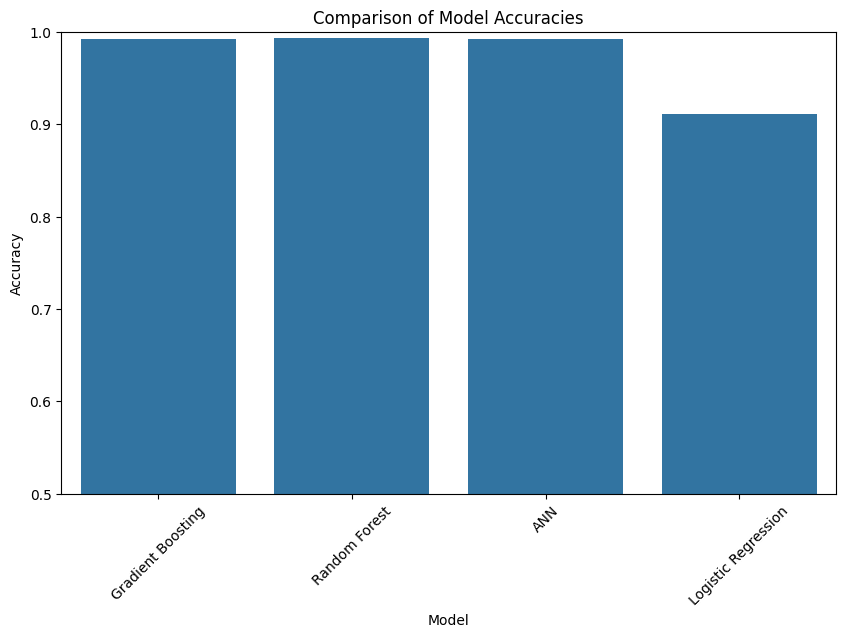

In [ ]:
accuracies = {
    'Gradient Boosting': accuracy_gbm,
    'Random Forest': accuracy_rf,
    'ANN': accuracy_ann,
    'Logistic Regression': accuracy_log_reg
}
# 데이터를 시각화하기 좋게 DataFrame으로 변환
accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])

# 바 차트 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df)
plt.title('Comparison of Model Accuracies')
plt.ylim(0.5, 1)  # Y축의 범위를 조정하여 차트의 차이를 더 잘 보이게 할 수 있습니다.
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)  # 모델 이름이 긴 경우 기울기 조정
plt.show()


                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Gradient Boosting    0.992230   1.000000  0.985312  0.992601  0.992656
Random Forest        0.992860   0.997597  0.988884  0.993222  0.993105
ANN                  0.992020   1.000000  0.984915  0.992400  0.992457
Logistic Regression  0.911382   1.000000  0.832473  0.908579  0.916237


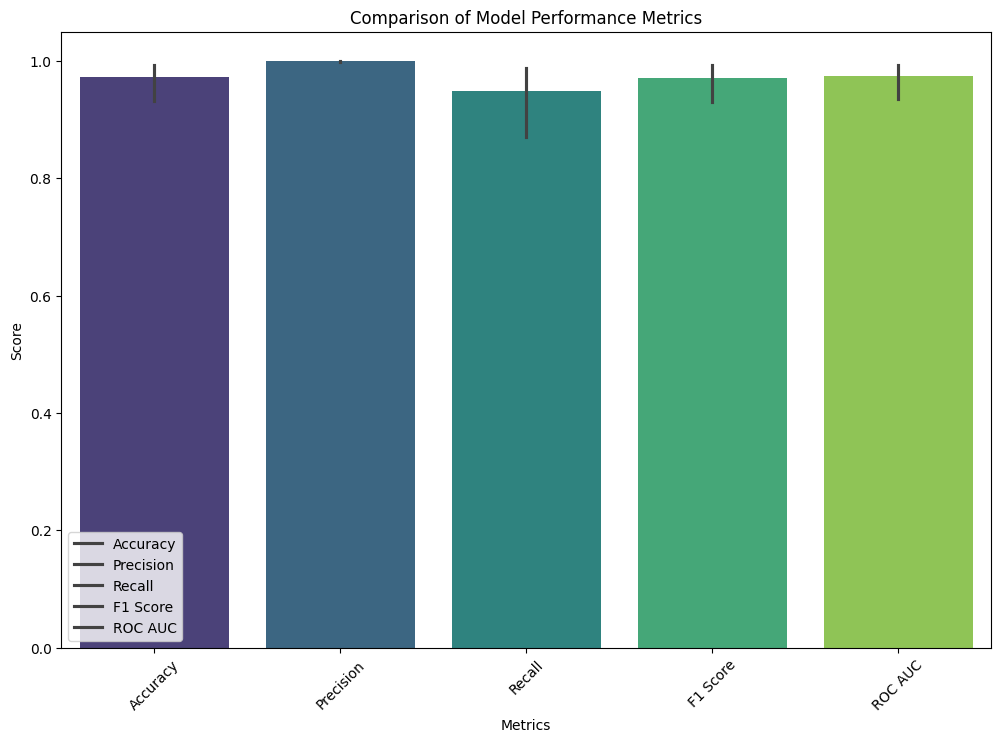

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# 각 모델의 예측 결과
y_preds = {
    'Gradient Boosting': y_pred_gbm,
    'Random Forest': y_pred_rf,
    'ANN': y_pred_ann,
    'Logistic Regression': y_pred_lr
}

# 비교할 성능 지표를 계산할 함수
def calculate_performance_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, roc_auc

# 성능 지표 계산
performance_metrics = {}
for model_name, y_pred in y_preds.items():
    accuracy, precision, recall, f1, roc_auc = calculate_performance_metrics(y_test, y_pred)
    performance_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# 결과 출력
performance_df = pd.DataFrame(performance_metrics).T
print(performance_df)

# 결과 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=performance_df, palette='viridis')
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.legend(performance_df.columns)
plt.show()


#표본 입력 예시

In [ ]:
# 100번째 행을 선택합니다.
row_100 = df.iloc[99]  # 인덱스는 0부터 시작하므로 99는 100번째 행을 의미합니다.

# 선택된 행을 출력합니다.
print("100번째 행의 값들:")
print(row_100)


100번째 행의 값들:
SMOK_QTY                25.000000
SMOK_STRT_AGE           98.000000
SMOK_DTRN_YCNT           1.000000
HORM_TRTM_YN             1.000000
HORM_TRTM_DTRN_DCNT     50.000000
HORM_TRTM_PRPS_CD        6.000000
MENO_YN                  1.000000
MENO_AGE                 8.000000
UCLN_PRGN_YN             1.000000
MENA_AGE                12.000000
target                   1.000000
Risk_Percentile_lr      62.417526
Risk_Percentile_rf     100.000000
Risk_Percentile_ann    100.000000
Risk_Percentile_gbm     99.981029
Name: 99, dtype: float64


In [ ]:
# 18346번째 행을 선택합니다.
row_18346 = df.iloc[18345]  # 인덱스는 0부터 시작하므로 99는 100번째 행을 의미합니다.

# 선택된 행을 출력합니다.
print("18346번째 행의 값들:")
print(row_18346)


18346번째 행의 값들:
SMOK_QTY                0.000000
SMOK_STRT_AGE           0.000000
SMOK_DTRN_YCNT          0.000000
HORM_TRTM_YN            0.000000
HORM_TRTM_DTRN_DCNT     0.000000
HORM_TRTM_PRPS_CD       0.000000
MENO_YN                 0.000000
MENO_AGE                0.000000
UCLN_PRGN_YN            0.000000
MENA_AGE               13.100000
target                  0.000000
Risk_Percentile_lr     -2.605390
Risk_Percentile_rf      0.000000
Risk_Percentile_ann     2.951061
Risk_Percentile_gbm     0.168826
Name: 18345, dtype: float64


In [ ]:
import pandas as pd


# 100번째 행을 선택합니다.
row_100 = df.iloc[[99]]
# 'DIAG_YN', 'Risk_score', 'Risk_Percentile'을 제외한 열을 사용하여 예측을 수행합니다.
input_data = row_100.drop(['Risk_Percentile_lr','Risk_Percentile_rf',
                           'Risk_Percentile_ann','Risk_Percentile_gbm'], axis=1)
new_predictions = rf.predict(input_data)

# 입력 데이터와 예측 결과를 함께 출력합니다.
print("입력 데이터:")
print(input_data)

# 예측 결과를 출력합니다.
print("새로운 데이터셋에 대한 예측 결과:", new_predictions)


입력 데이터:
    SMOK_QTY  SMOK_STRT_AGE  SMOK_DTRN_YCNT  HORM_TRTM_YN  \
99      25.0           98.0             1.0           1.0   

    HORM_TRTM_DTRN_DCNT  HORM_TRTM_PRPS_CD  MENO_YN  MENO_AGE  UCLN_PRGN_YN  \
99                 50.0                6.0      1.0       8.0           1.0   

    MENA_AGE  target  
99      12.0     1.0  
새로운 데이터셋에 대한 예측 결과: [1.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
import pandas as pd


# 100번째 행을 선택합니다.
row_18346 = df.iloc[[18345]]
# 'DIAG_YN', 'Risk_score', 'Risk_Percentile'을 제외한 열을 사용하여 예측을 수행합니다.
input_data2 = row_18346.drop(['Risk_Percentile_lr','Risk_Percentile_rf',
                           'Risk_Percentile_ann','Risk_Percentile_gbm'], axis=1)
new_predictions2 = rf.predict(input_data)

# 입력 데이터와 예측 결과를 함께 출력합니다.
print("입력 데이터:")
print(input_data2)

# 예측 결과를 출력합니다.
print("새로운 데이터셋에 대한 예측 결과:", new_predictions2)


입력 데이터:
       SMOK_QTY  SMOK_STRT_AGE  SMOK_DTRN_YCNT  HORM_TRTM_YN  \
18345       0.0            0.0             0.0           0.0   

       HORM_TRTM_DTRN_DCNT  HORM_TRTM_PRPS_CD  MENO_YN  MENO_AGE  \
18345                  0.0                0.0      0.0       0.0   

       UCLN_PRGN_YN  MENA_AGE  target  
18345           0.0      13.1     0.0  
새로운 데이터셋에 대한 예측 결과: [1.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


#점수 분포도

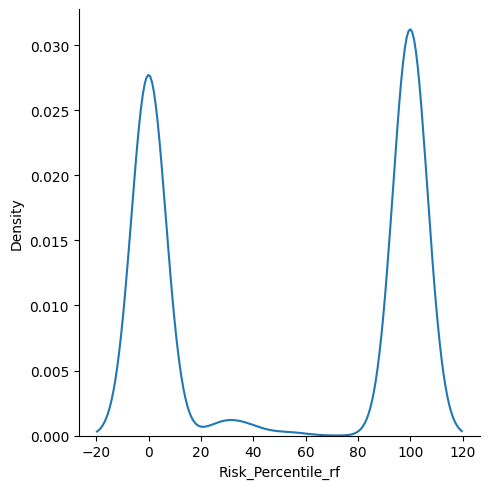

In [ ]:
import seaborn as sns

sns.displot(data=df, x='Risk_Percentile_rf', kind='kde')


<ipython-input-64-e960e20dfd8a>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df['Risk_Percentile_rf'], kde=True, rug=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from

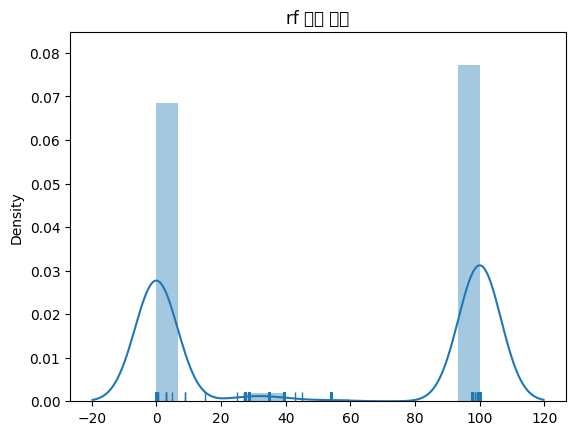

In [ ]:
sns.distplot(x=df['Risk_Percentile_rf'], kde=True, rug=True)
plt.title("rf 점수 분포")
plt.show()

#위험군 분류

##범위 계산

In [ ]:
# # 'Risk_Percentile'의 중앙값 계산
# median_risk_score_diag_yn_1_gbm = target_1_df['Risk_Percentile_gbm'].median()

# print(f"Median Risk Score 환자군 gbm: {median_risk_score_diag_yn_1_gbm}")

##분류

In [ ]:
# risk_percentile_gbm_18346 = df.loc[18345, 'Risk_Percentile_gbm']
# print("18346번째 행의 'Risk_Percentile_gbm':", risk_percentile_gbm_18346)


In [ ]:

# # 고위험군과 위험군을 판단하는 함수
# def risk_group(score):
#     if min_risk_score_diag_yn_1_gbm <= score < median_risk_score_diag_yn_1_gbm:
#         return '위험군입니다.'
#     elif median_risk_score_diag_yn_1_gbm <= score <= max_risk_score_diag_yn_1_gbm:
#         return '고위험군입니다.'
#     else:
#         return '저위험군입니다.'


# # 고위험군 또는 위험군을 판단합니다.
# result2 = risk_group(risk_percentile_gbm_18346)

# # 결과 출력
# print("예측된 점수:", risk_percentile_gbm_18346)
# print(result2)

##점수 정확도 분석

In [ ]:
# 'Risk_Percentile_rf' 칼럼의 값과 'target' 칼럼의 값을 가져옴
risk_percentile = df['Risk_Percentile_rf']
target = df['target']


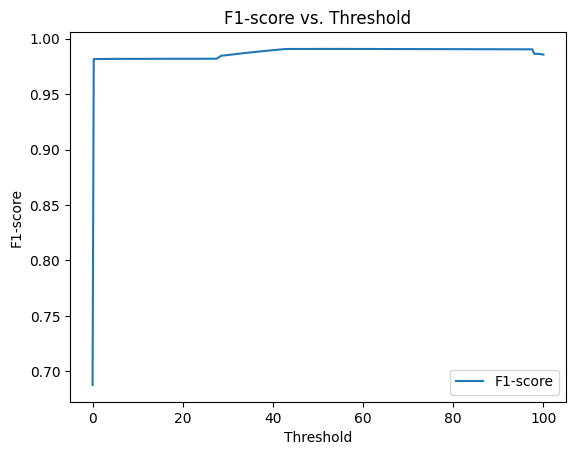

Best Threshold: 53.90634523517397
Best F1-score: 0.9906511927788524
Corresponding Precision: 0.9964332036316472
Corresponding Recall: 0.9849358974358975


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# 정밀도, 재현율, 임계값 계산
precision, recall, thresholds = precision_recall_curve(target, risk_percentile)

# F1-score 계산
f1_scores = [f1_score(target, (risk_percentile >= threshold).astype(int)) for threshold in thresholds]

# F1-score와 thresholds 간 관계 시각화
plt.plot(thresholds, f1_scores, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score vs. Threshold')
plt.legend()
plt.show()

# 최적의 임계값 선택
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]
best_precision = precision[best_threshold_index]
best_recall = recall[best_threshold_index]

print("Best Threshold:", best_threshold)
print("Best F1-score:", best_f1_score)
print("Corresponding Precision:", best_precision)
print("Corresponding Recall:", best_recall)

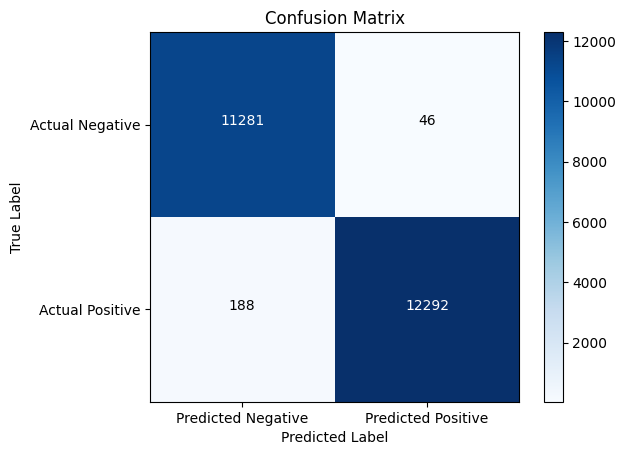

In [ ]:
# 주어진 임계값
threshold = 40.13314220343852

# 임계값을 기준으로 이진 분류 수행
predicted = (risk_percentile >= threshold).astype(int)

# 혼동 행렬 계산
tn, fp, fn, tp = confusion_matrix(target, predicted).ravel()

# 혼동 행렬 시각화
conf_matrix = np.array([[tn, fp], [fn, tp]])
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', color='white' if conf_matrix[i, j] > (conf_matrix.max() / 2) else 'black')

plt.show()

In [ ]:
# 재현율과 정밀도 계산
recall = recall_score(target, predicted)
precision = precision_score(target, predicted)

print("Recall:", recall)
print("Precision:", precision)

Recall: 0.9849358974358975
Precision: 0.9962716809855731


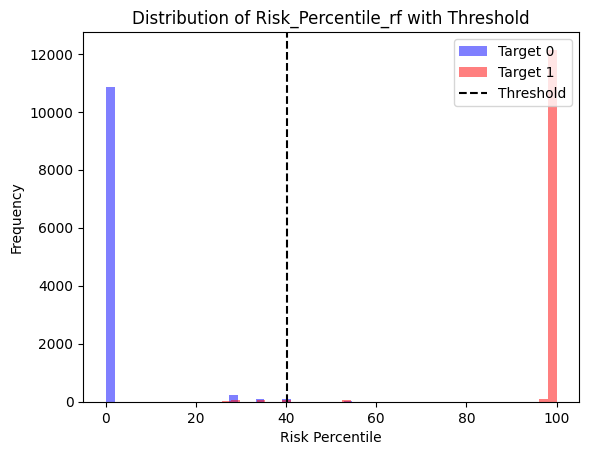

In [ ]:
# 'target'이 0인 표본과 1인 표본을 나누기
target_0 = df[df['target'] == 0]['Risk_Percentile_rf']
target_1 = df[df['target'] == 1]['Risk_Percentile_rf']

# 히스토그램을 통해 시각화
plt.hist(target_0, bins=50, color='blue', alpha=0.5, label='Target 0')
plt.hist(target_1, bins=50, color='red', alpha=0.5, label='Target 1')
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Risk Percentile')
plt.ylabel('Frequency')
plt.title('Distribution of Risk_Percentile_rf with Threshold')
plt.legend()
plt.show()